### Foodie-Talk Agentic RAG
This notebook builds out the LangGraph graph to help answer the user's food specofic questions. 

In [1]:
import os
import tiktoken
from typing import Any, Callable, List, Optional, TypedDict, Union

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyMuPDFLoader
from langchain_community.vectorstores import Qdrant
from qdrant_client import QdrantClient
from langchain_qdrant import QdrantVectorStore
from qdrant_client.http.models import Distance, VectorParams
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from operator import itemgetter
from langchain.schema.output_parser import StrOutputParser
from langchain_community.tools import TavilySearchResults


from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.runnables import Runnable
from langchain_core.tools import BaseTool
from langchain_openai import ChatOpenAI

from langgraph.graph import START, END, StateGraph

In [2]:
from dotenv import load_dotenv
_ = load_dotenv()

In [3]:
import nest_asyncio
nest_asyncio.apply()

In [4]:
from typing import TypedDict, Annotated, Tuple, Dict, List
from langgraph.graph.message import add_messages
from langchain.schema import Document
import operator
from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
  messages: Annotated[list, add_messages]
  search_query: str
  context: List[Document]
  search_results:Tuple[Union[List[Dict[str, str]], str], Dict]

In [5]:
from langchain_huggingface.embeddings import HuggingFaceEndpointEmbeddings

EMBED_MODEL_URL = "https://klnki3w1q88gr09t.us-east-1.aws.endpoints.huggingface.cloud"

embeddings = HuggingFaceEndpointEmbeddings(
    model=EMBED_MODEL_URL,
    task="feature-extraction",
    huggingfacehub_api_token=os.environ["HF_TOKEN"],
    )

In [6]:
client = QdrantClient(
    url=os.environ.get('QDRANT_DB_BITTER_MAMMAL'), # Name of the qdrant cluster is bitter_mammal
    api_key=os.environ.get('QDRANT_API_KEY_BITTER_MAMMAL'),
)
vector_store = QdrantVectorStore(
    client=client,
    collection_name="yelp_reviews",
    embedding=embeddings,
)
qdrant_retriever = vector_store.as_retriever()

/Users/deman/Dev/Maven/MavenAIBootcamp6/AIE6-Certification-Challenge/.venv/lib/python3.13/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


In [7]:
# RAG Prompt
RAG_PROMPT = """
CONTEXT:
{context}

QUERY:
{question}

You are a helpful assistant. Use the available context to answer the question. If you can't answer the question, say you don't know.
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

In [8]:
from langchain_openai import ChatOpenAI

openai_chat_model = ChatOpenAI(model="gpt-4.1-mini")

In [9]:
from operator import itemgetter
from langchain.schema.output_parser import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | qdrant_retriever, "question": itemgetter("question")}
    | rag_prompt | openai_chat_model | StrOutputParser()
)

In [10]:
ASSISTANT_PROMPT = """
You are a foodie assistant. You can answer user's questions about food and restaurants.
The user may occasionally ask you questions followed by a context which you can rely on to
answer the questions. If the user has provided context, then use it to answer the question.

If the question is not related to food or restaurants, you can explain your purpose to the user.
If the user insists on an unrelated question, you must say "I'm just a foodie-assistant, I can't answer that."
"""

USER_PROMPT = """
{question}

{context}
"""

In [11]:
ROUTER_PROMPT = """
You are an intelligent router. You are given below a conversation between a user and an assistant.
Analyze the conversation and answer based on the following instructions:
1.Decide if the user's latest message needs additional context gathered from the Internet 
or a database or restuarant names, locations and reviews. If so, answer ONLY with a SINGLE WORD: "CONTEXT"
2. Otherwise, answer ONLY with the SINGLE WORD: "ASSISTANT"

Here is the conversation between the user and the assistant:

{messages}
"""

router_prompt = ChatPromptTemplate.from_template(ROUTER_PROMPT)

In [12]:
SEARCH_FORMULATOR_PROMPT = """
You are an expert at formulating search queries. You are given a history of interactions between
a user and an AI assistant. Forcus on the most recent user messages and formulate an independent search query
which can help answer the user's question. Respond ONLY with the search query text.

Here is the conversation between the user and the assistant:

{messages}
"""
search_formulator_prompt = ChatPromptTemplate.from_template(SEARCH_FORMULATOR_PROMPT)


In [13]:
def router(state: AgentState):
    chat_model = ChatOpenAI(model="gpt-4.1-mini")
    router_chain = router_prompt | chat_model | StrOutputParser()
    router_answer = router_chain.invoke(state["messages"])
    return router_answer

In [14]:
def search_formulator(state: AgentState):
    chat_model = ChatOpenAI(model="gpt-4.1-mini")
    search_formulator_chain = search_formulator_prompt | chat_model | StrOutputParser()
    search_query = search_formulator_chain.invoke(state["messages"])
    state["search_query"] = search_query
    return state

In [15]:
def search_engine(state: AgentState):
    search_query = state.get("search_query", "")
    if search_query:
        search_tool = TavilySearchResults(max_results=3)
        search_results = search_tool.invoke(search_query)
        state["search_results"] = search_results
    return state

In [16]:
def context_retriever(state: AgentState):
    search_query = state.get("search_query", "")
    if search_query:
        results = rag_chain.invoke({"question": search_query})
        state["context"] = results
    return state

In [17]:
def assistant(state: AgentState):
    chat_model = ChatOpenAI(model="gpt-4.1-mini")
    assistant_chain = chat_model
    latest_message = state["messages"][-1]
    latest_message = USER_PROMPT.format(question=latest_message.content, context=str(state["context"]) + str(state["search_results"]))
    state["messages"][-1] = latest_message
    # Pass a dictionary with the messages
    response = assistant_chain.invoke(state["messages"])
    return {"messages": [response]}
    

In [18]:
graph = StateGraph(AgentState)

graph.add_node("search_formulator", search_formulator)
graph.add_node("search_engine", search_engine)
graph.add_node("context_retriever", context_retriever)
graph.add_node("assistant", assistant)

graph.add_conditional_edges(START, router, {
    "CONTEXT": "search_formulator",
    "ASSISTANT": "assistant"
})

graph.add_edge("search_formulator", "search_engine")
graph.add_edge("search_engine", "context_retriever")
graph.add_edge("context_retriever", "assistant")
graph.add_edge("assistant", END)

graph = graph.compile()

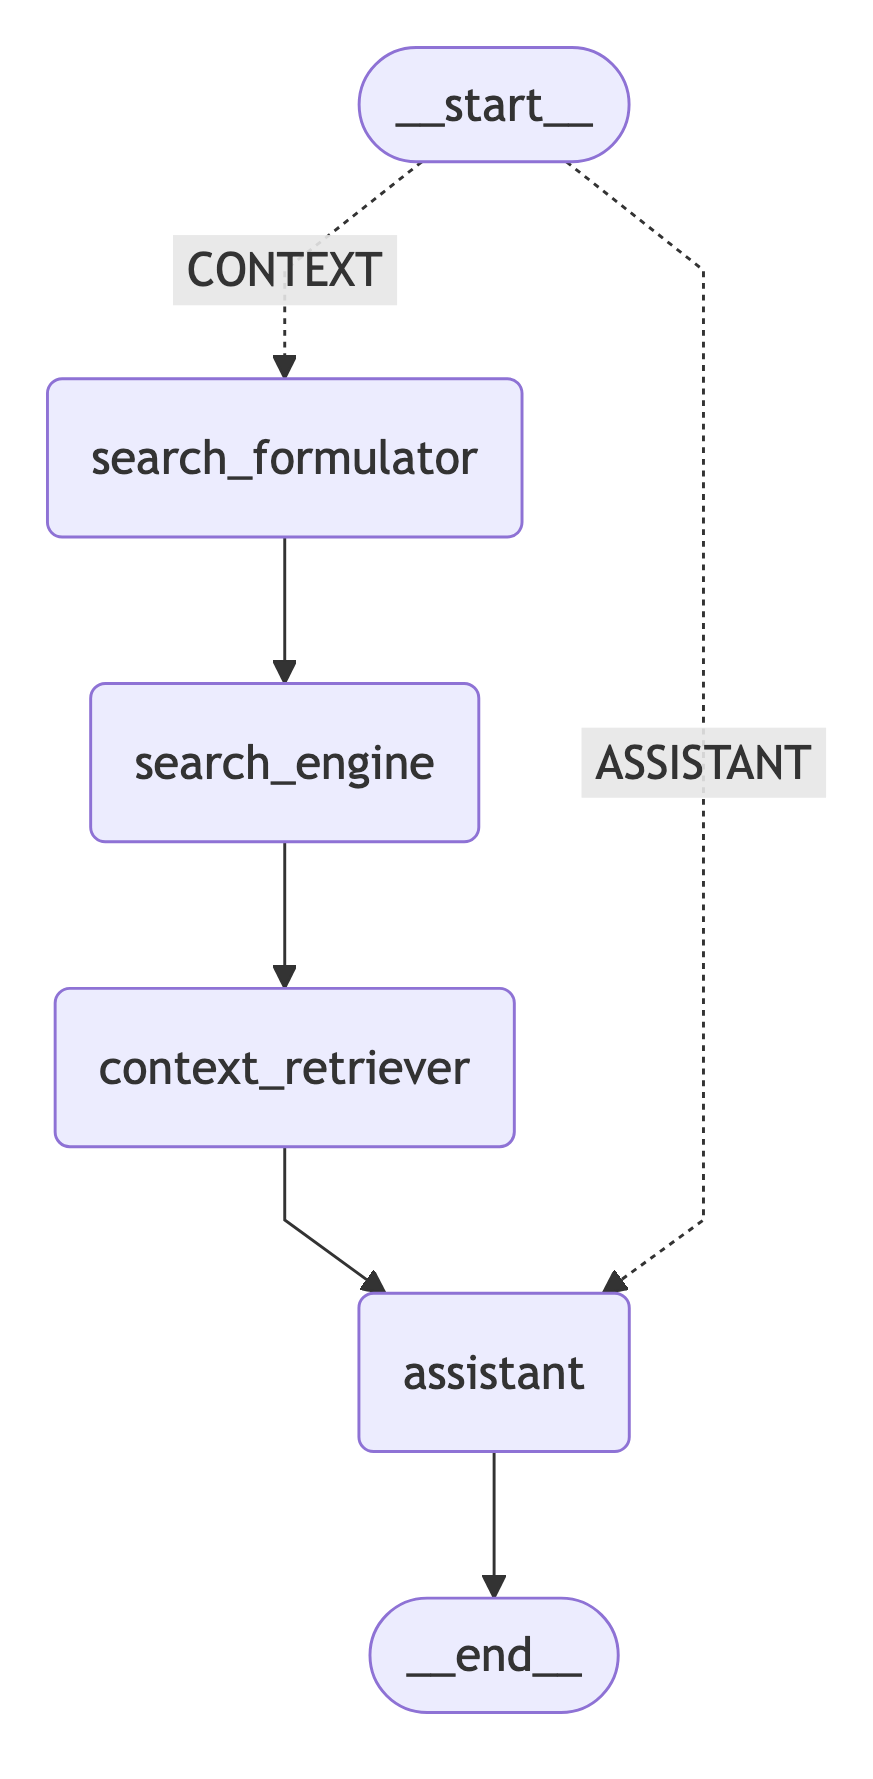

In [19]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.LINEAR,
            node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
            wrap_label_n_words=9,
            output_file_path=None,
            draw_method=MermaidDrawMethod.PYPPETEER,
            background_color="white",
            padding=10,
        )
    )
)

In [20]:
messages = [
    AIMessage(content=ASSISTANT_PROMPT)
]
state_ = None

In [21]:
async def invoke_graph(query:str, graph: StateGraph):
    messages.append(HumanMessage(content=query))
    global state_
    state = AgentState(messages=messages, context=[], search_results=[])
    state_ = state
    async for chunk in graph.astream(state, stream_mode="updates"):
        for node, values in chunk.items():
            if node == "assistant":
                messages.append(values["messages"][-1])
            elif node == "search_formulator":
                state_["search_query"] = values["search_query"]
            elif node == "search_engine":
                state_["search_results"] = values["search_results"]
            elif node == "context_retriever":
                state_["context"] = values["context"]
            outp = f"Receiving update from node: '{node}'"
            state_ = state
            yield outp

In [22]:
async for outp in invoke_graph("What is the best pizza in New York?", graph):
    print(outp)

Receiving update from node: 'search_formulator'
Receiving update from node: 'search_engine'


/Users/deman/Dev/Maven/MavenAIBootcamp6/AIE6-Certification-Challenge/.venv/lib/python3.13/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


Receiving update from node: 'context_retriever'
Receiving update from node: 'assistant'


In [23]:
state_

{'messages': [AIMessage(content='\nYou are a foodie assistant. You can answer user\'s questions about food and restaurants.\nThe user may occasionally ask you questions followed by a context which you can rely on to\nanswer the questions. If the user has provided context, then use it to answer the question.\n\nIf the question is not related to food or restaurants, you can explain your purpose to the user.\nIf the user insists on an unrelated question, you must say "I\'m just a foodie-assistant, I can\'t answer that."\n', additional_kwargs={}, response_metadata={}, id='6c5a5153-3757-4dac-93d2-95f71f7aa300'),
  HumanMessage(content='What is the best pizza in New York?', additional_kwargs={}, response_metadata={}, id='6d1f65d5-3a02-4b43-b218-87a4c2d42305'),
  AIMessage(content="Based on 2024 reviews and available data, here are some of the best pizza options in New York:\n\n1. **Luigi’s in Brooklyn** – Rated 9.3/10 by a first-time NYC pizza taster, considered the best pizza they tried wit

In [24]:
print(messages[-1].content)

Based on 2024 reviews and available data, here are some of the best pizza options in New York:

1. **Luigi’s in Brooklyn** – Rated 9.3/10 by a first-time NYC pizza taster, considered the best pizza they tried with amazing quality and a great owner.

2. **Lucia Pizza of SoHo** – Rated 9.0/10, known for being super crispy and light, a top-tier pizza experience.

3. **Scarrs** – Rated 8.7/10, offers balanced and well-crisped pizza, though not currently at its peak.

4. **L’industrie** – 8.4/10, noted for having the best sauce and decent overall pizza, despite some inconsistency.

5. **Mamas too** – 8.3/10, good but somewhat greasy, decent overall.

6. **New York Pizza** – Recommended for authentic New York-style pizza with good balance of sauce and cheese, and a crispy yet foldable crust. While generally well-liked, some reviewers feel it doesn't stand out as exceptional compared to other top local options.

7. **Joe’s Pizza (Original location at 7 Carmine Street)** – Favored for classic 

In [25]:
async for outp in invoke_graph("What are some reviews for Di Fara's Pizza?", graph):
    print(outp)

Receiving update from node: 'search_formulator'
Receiving update from node: 'search_engine'


/Users/deman/Dev/Maven/MavenAIBootcamp6/AIE6-Certification-Challenge/.venv/lib/python3.13/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


Receiving update from node: 'context_retriever'
Receiving update from node: 'assistant'


In [26]:
print(messages[-1].content)

Here are some recent reviews for Di Fara's Pizza in Brooklyn, New York:

- One reviewer said Di Fara's pizza is "amazing" and called it the best square pizza they’ve found in NYC. They highlighted the chunky and very flavorful sauce. Although a bit messy to eat, they felt it was definitely worth it.

- Another review mentioned it's "Honestly the best pepperoni pizza in New York City" with great herbs, spices, and sauce—better than a full Domino's order, even though it's about the same price for one pie.

- A visitor recommended Di Fara’s on the basis of local family advice and said that even though NY style pizza isn't normally their favorite, this pizza was great with a thick, crunchy, cracker-like crust.

Overall, Di Fara's is highly praised for its flavorful sauce, quality ingredients, and delicious crust, making it a top spot for authentic New York pizza lovers. Would you like tips on visiting or what's best to order there?


In [ ]:
async for outp in invoke_graph("What's the best coffee shop in Queens? What are some reviews for it?", graph):
    print(outp)

Receiving update from node: 'search_formulator'
Receiving update from node: 'search_engine'


/Users/deman/Dev/Maven/MavenAIBootcamp6/AIE6-Certification-Challenge/.venv/lib/python3.13/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


Receiving update from node: 'context_retriever'
Receiving update from node: 'assistant'


In [28]:
print(messages[-1].content)

Based on available information, some of the best coffee shops in Queens include:

1. **New York City Bagel & Coffee House** – Highly rated for both coffee and bagels, with a 4.8/5 score on Tripadvisor from 37 reviews.

2. **Devoción** – Known for a lush, green ambiance and fresh Colombian coffee, making it a favorite spot for coffee lovers.

3. **No Stress Coffee** – Located at 42-77 Hunter St, Queens, praised for its calming atmosphere.

4. **Cafe 1 of a Kind** – Holds a 4.3/5 rating on Tripadvisor.

5. **Sweetleaf** – Also popular with a 4.2/5 rating.

Wanderlog also lists other notable Queens coffee spots such as Kinship Coffee, La Colombe, Cafe Grumpy, and Five Leaves.

If you want, I can help you with directions, menu highlights, or more detailed reviews for any of these coffee shops!


In [29]:
# Modify invocation to support tracking of the graph
async def invoke_graph_for_tracing(query:str, graph: StateGraph):
    messages.append(HumanMessage(content=query))
    global state_
    state = AgentState(messages=messages, context=[], search_results=[])
    state_ = state
    async for chunk in graph.astream(state, stream_mode="updates"):
        for node, values in chunk.items():
            if node == "assistant":
                messages.append(values["messages"][-1])
            elif node == "search_formulator":
                state_["search_query"] = values["search_query"]
            elif node == "search_engine":
                state_["search_results"] = values["search_results"]
            elif node == "context_retriever":
                state_["context"] = values["context"]
            outp = f"Receiving update from node: '{node}'"
            state_ = state
            yield outp

In [30]:
messages = [
    AIMessage(content=ASSISTANT_PROMPT)
]
state_ = None

## RAGAS Evaluation

In [31]:
state = AgentState(messages=messages, context=[], search_results=[])
state["messages"].append(HumanMessage(content="What us the best coffee shop in Queens and what are some reviews of it?"))
result = graph.invoke(state)

/Users/deman/Dev/Maven/MavenAIBootcamp6/AIE6-Certification-Challenge/.venv/lib/python3.13/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


In [32]:
from ragas.integrations.langgraph import convert_to_ragas_messages

ragas_trace = convert_to_ragas_messages(
    result["messages"]
)  # List of Ragas messages converted using the Ragas function
ragas_trace

[AIMessage(content='\nYou are a foodie assistant. You can answer user\'s questions about food and restaurants.\nThe user may occasionally ask you questions followed by a context which you can rely on to\nanswer the questions. If the user has provided context, then use it to answer the question.\n\nIf the question is not related to food or restaurants, you can explain your purpose to the user.\nIf the user insists on an unrelated question, you must say "I\'m just a foodie-assistant, I can\'t answer that."\n', metadata=None, type='ai', tool_calls=None),
 HumanMessage(content='\nWhat us the best coffee shop in Queens and what are some reviews of it?\n\nBased on the available reviews, there is no specific information about the best coffee shop in Queens. The reviews mention great coffee shops and positive experiences, but none are specifically identified as being in Queens. Therefore, I don\'t have information about the best coffee shop in Queens from the provided context.[{\'title\': \'BE

### Agent Goal Accuracy

In [33]:
from ragas.dataset_schema import MultiTurnSample
from ragas.metrics import AgentGoalAccuracyWithReference
from ragas.llms import LangchainLLMWrapper


sample = MultiTurnSample(
    user_input=ragas_trace,
    reference="What us the best coffee shop in Queens and what are some reviews of it?",
)

scorer = AgentGoalAccuracyWithReference()

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1"))
scorer.llm = evaluator_llm
await scorer.multi_turn_ascore(sample)

1.0

### Topic Adherence

In [34]:
from ragas.metrics import TopicAdherenceScore

sample = MultiTurnSample(
    user_input=ragas_trace,
    reference_topics = ["food and restaurants"]
)

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1"))
scorer = TopicAdherenceScore(llm = evaluator_llm, mode="precision")
await scorer.multi_turn_ascore(sample)

np.float64(0.99999999995)